<a href="https://colab.research.google.com/github/ariabishma/learn-machinelearning/blob/main/Road_To_GPT_Positional_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-05-09 09:36:06--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.1s    

2023-05-09 09:36:06 (8.50 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [3]:
import tensorflow as tf
import numpy as np 

In [4]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

## Character Level Encoder - Decoder

In [6]:
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
data = np.array(encode(text))

## Batch Preparation

In [8]:
n = int(0.9*len(data)) # train validation split

In [9]:
train_data = data[:n]
val_data = data[n:]

In [10]:
block_size = 8 
train_data[:block_size+1]

array([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [11]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is [18] the target: 47
when input is [18 47] the target: 56
when input is [18 47 56] the target: 57
when input is [18 47 56 57] the target: 58
when input is [18 47 56 57 58] the target: 1
when input is [18 47 56 57 58  1] the target: 15
when input is [18 47 56 57 58  1 15] the target: 47
when input is [18 47 56 57 58  1 15 47] the target: 58


In [12]:
random = np.random.randint(len(data) - block_size)
print("x : ",decode(data[random:random+block_size]))
print("y : ",decode(data[random+1:random+block_size+1]))

x :  empt him
y :  mpt him 


In [13]:
batch_size = 10 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = np.random.randint(len(data) - block_size, size = (batch_size,)) # generate random text position 
    x = np.stack([data[i:i+block_size] for i in ix])
    y = np.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')

# Experiment

## Sinusoidal positional encoder

Formula : 

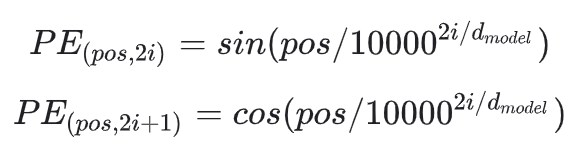


In [14]:
import numpy as np 
import matplotlib.pyplot as plt

In [15]:
batch = 4
context_length = 8
depth = 32 # embedding vector depth

In [16]:
def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=context_length, d=depth)

pos_batch = np.array([getPositionEncoding(seq_len=context_length, d=depth) for _ in range(batch)])
print(pos_batch.shape)

(4, 8, 32)


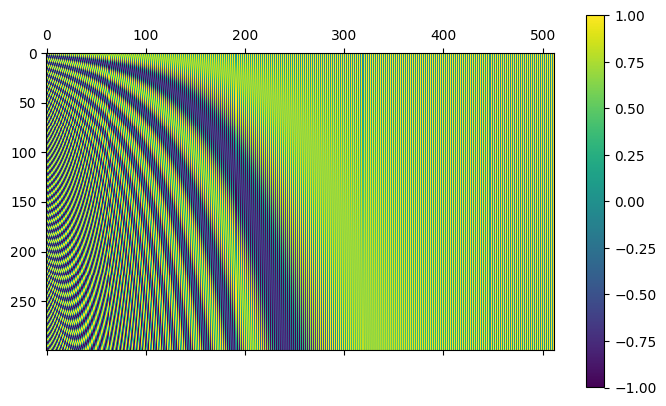

In [17]:
P = getPositionEncoding(seq_len=300, d=512)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

## Cross entropy loss

In [18]:
y_true = tf.Variable([0,1])
y_pred = tf.Variable([1,0], dtype='float64')

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss(y_true, y_pred).numpy()

1.3132616875182228

## masked fill

In [19]:
tensor = tf.Variable(np.random.randint(1,5,size=(6,6)), dtype='float32')
mask = tf.linalg.band_part(tf.ones((6,6),dtype='bool'), -1, 0)
lgts = tf.where(mask, tensor, float('-inf'))
lgts

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[  2., -inf, -inf, -inf, -inf, -inf],
       [  4.,   2., -inf, -inf, -inf, -inf],
       [  2.,   2.,   4., -inf, -inf, -inf],
       [  2.,   3.,   1.,   4., -inf, -inf],
       [  3.,   2.,   2.,   3.,   1., -inf],
       [  2.,   1.,   4.,   2.,   2.,   4.]], dtype=float32)>

# The Model

In [93]:
class InputEmbedding(tf.keras.layers.Layer):
  """ Input Embedding + positional encoding """
  def __init__(self):
    super().__init__()
    self.input_embedding = tf.keras.layers.Embedding(input_dim = vocab_size, output_dim = vocab_size)
    self.positional_embedding = tf.keras.layers.Embedding(input_dim = block_size, output_dim = vocab_size)

  def call(self,x):
    B, T = x.shape
     
    positional_embedding = self.positional_embedding(np.arange(T))
    logits = self.input_embedding(x) + positional_embedding
    
    return logits

In [94]:
class MaskedSelfAttention(tf.keras.layers.Layer):
  """ Masked self attention """
  def __init__(self):
    super().__init__()
    self.embedding = InputEmbedding()
    self.head_size = vocab_size

    self.query = tf.keras.layers.Dense(self.head_size, use_bias=False, name="query_weight") 
    self.key = tf.keras.layers.Dense(self.head_size, use_bias=False, name="key_weight") 
    self.value = tf.keras.layers.Dense(self.head_size, use_bias=False, name="value_weight") 

  def call(self,input):
    B,T,C = input.shape 

    query = self.query(input)
    key = tf.transpose(self.key(input),perm=[0,2,1])
    value = self.value(input)

    wei = query @ key / np.sqrt(self.head_size)

    mask = tf.linalg.band_part(tf.ones(wei.shape ,dtype='bool'), -1, 0)
    wei = tf.nn.softmax(tf.where(mask, wei, float('-inf')))

    logits = wei @ value

    return logits

In [102]:
class LanguageModel(tf.keras.Model):
  def __init__(self):
    super().__init__()
    self.input_embedding = InputEmbedding()
    self.attention = MaskedSelfAttention()  # Single Head self-attention
    self.norm = tf.keras.layers.LayerNormalization()
    self.linear = tf.keras.layers.Dense(vocab_size, activation='softmax')
    self.cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

  
  def call(self, input, target=None):
    x = self.input_embedding(input)
    x = self.attention(x)
    x = self.norm(x)
    logits = self.linear(x)
    
    target = tf.one_hot(yb,vocab_size)
    loss = self.cross_entropy(logits, target)

    return loss, logits

In [106]:
model = LanguageModel()
loss, logits = model(xb, yb)
print('Loss : ',loss.numpy())

Loss :  4.1861296


In [107]:
model.summary()

Model: "language_model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_embedding_61 (InputEm  multiple                 4745      
 bedding)                                                        
                                                                 
 masked_self_attention_29 (M  multiple                 12675     
 askedSelfAttention)                                             
                                                                 
 layer_normalization_2 (Laye  multiple                 130       
 rNormalization)                                                 
                                                                 
 dense_28 (Dense)            multiple                  4290      
                                                                 
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
_____________________________________________